In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mushroom-classification/mushrooms.csv


# Anàlisi i Classificació de Bolets (Mushroom Classification)

Aquest projecte té com a objectiu analitzar les característiques físiques dels bolets per predir si són comestibles o verinosos. El dataset conté descripcions de mostres hipotètiques corresponents a 23 espècies de bolets de la família Agaricus i Lepiota.

## 1. Importació de llibreries i càrrega de dades

Primer, carregarem les llibreries essencials que s'utilitzaran al llarg de la solució desenvolupada, carreguem el dataset i configurem la visualització.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Càrrega del dataset
df = pd.read_csv('/kaggle/input/mushroom-classification/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 2. Anàlisi Exploratòria de Dades (EDA)

### Revisió d'estructura i valors nuls

In [3]:
print(f"Dimensions del dataset: {df.shape}")
print("\nInformació general:")
df.info()

print("\nRevisió de valors nuls:")
print(df.isnull().sum())

Dimensions del dataset: (8124, 23)

Informació general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ri

A primera vista es pot observar que el dataset està totalment net de NaNs i també que és totalment categòric.

In [7]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

class: ['p' 'e']
cap-shape: ['x' 'b' 's' 'f' 'k' 'c']
cap-surface: ['s' 'y' 'f' 'g']
cap-color: ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises: ['t' 'f']
odor: ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment: ['f' 'a']
gill-spacing: ['c' 'w']
gill-size: ['n' 'b']
gill-color: ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape: ['e' 't']
stalk-root: ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring: ['s' 'f' 'k' 'y']
stalk-surface-below-ring: ['s' 'f' 'y' 'k']
stalk-color-above-ring: ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring: ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type: ['p']
veil-color: ['w' 'n' 'o' 'y']
ring-number: ['o' 't' 'n']
ring-type: ['p' 'e' 'l' 'f' 'n']
spore-print-color: ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population: ['s' 'n' 'a' 'v' 'y' 'c']
habitat: ['u' 'g' 'm' 'd' 'p' 'w' 'l']


Al ser un dataset categòric amb un nombre relativament baix d'atributs, hem llistat totes les possibles classes de cadascun per assegurar-nos de no trobar-nos amb cap classe que ens fés mal interpretar l'anàlisi de NaNs anterior. Ens hem trobat amb la classe "?" a stalk-root. Tanmateix, com que tractarem les dades com a categories, el "?" es pot considerar simplement com una categoria més ("desconegut").

### Distribució de la variable objectiu
La variable class és la que volem predir: e (edible/comestible) o p (poisonous/verinós).

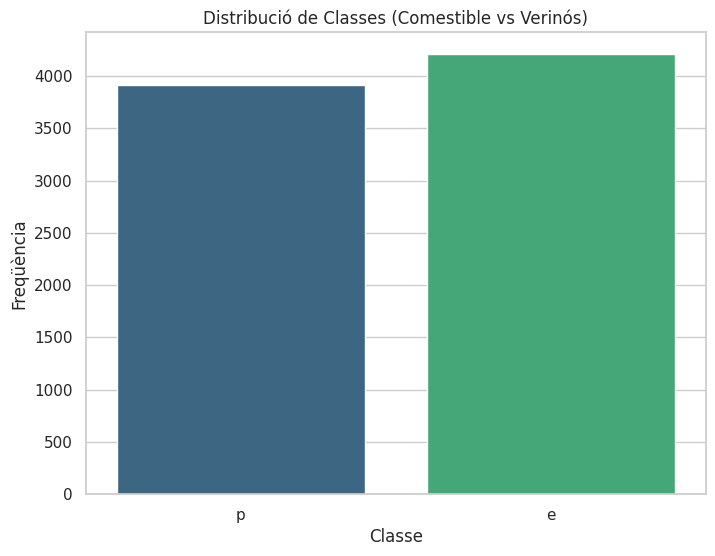

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Distribució de Classes (Comestible vs Verinós)')
plt.xlabel('Classe')
plt.ylabel('Freqüència')
plt.show()

Aquesta descripció gràfica ens mostra com al dataset hi ha unes quantitats molt comparables de bolets comestibles i verinosos, per tant podem concloure que el dataset és equilibrat.

### Visualització d'atributs clau
Analitzem atributs visualment, el que ens ajudarà a intuir quins atributs discriminen millor i quins són més valuosos. Apliquem una escala logarítmica a l'eix Y per fer notar més les petites mostres.

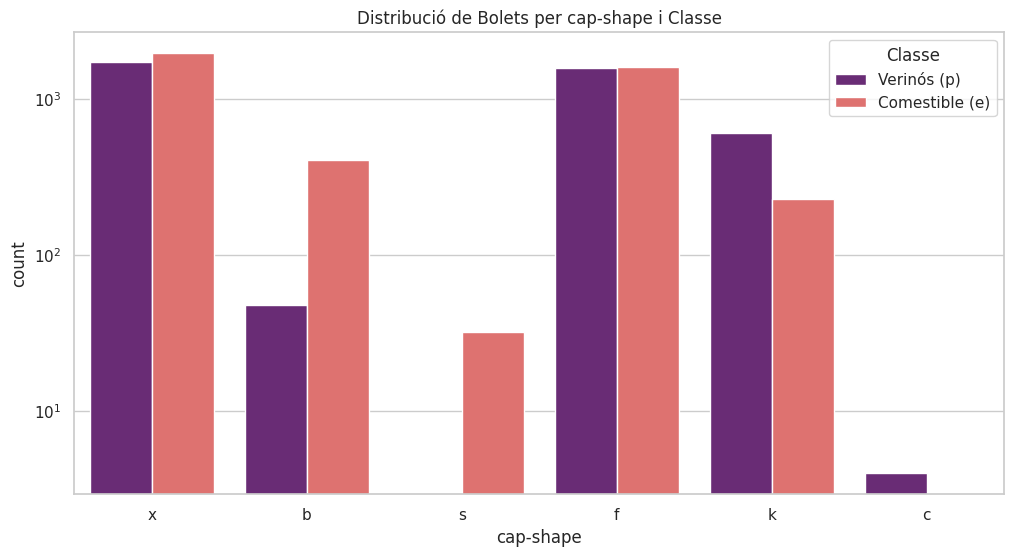

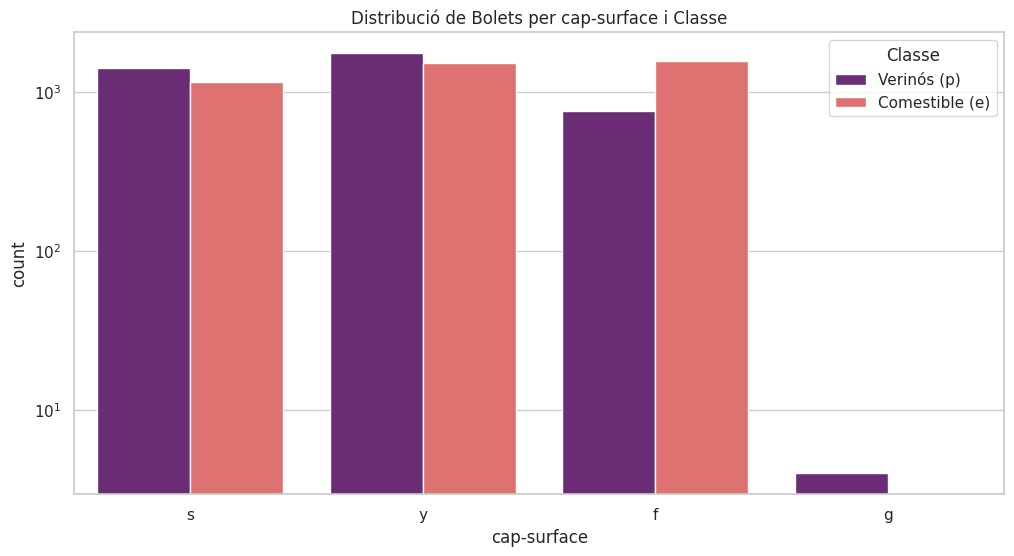

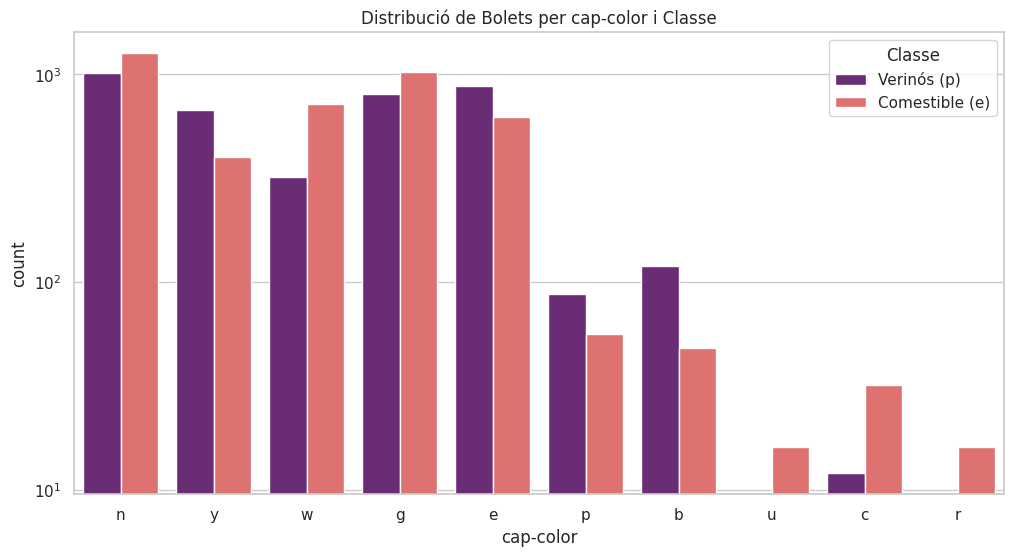

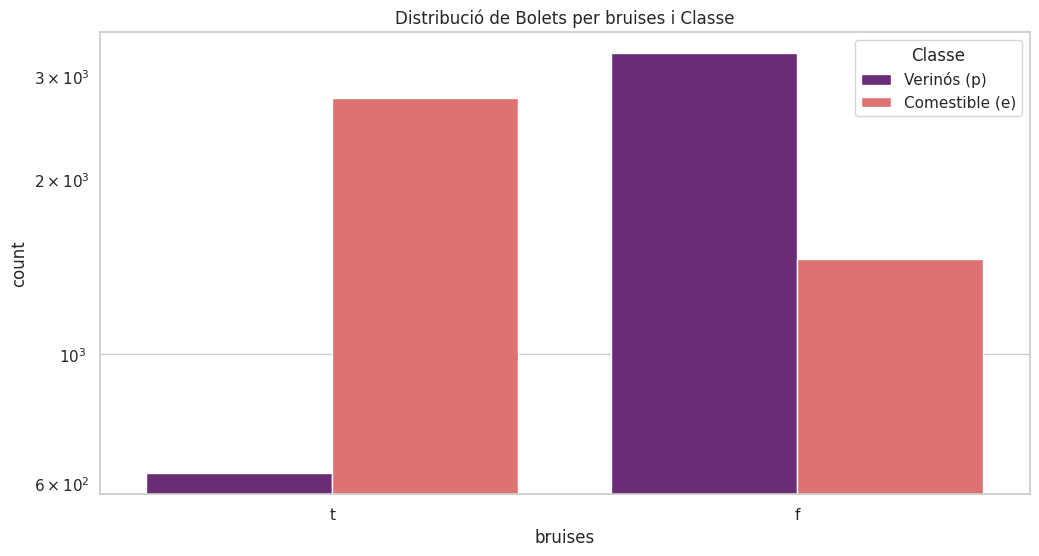

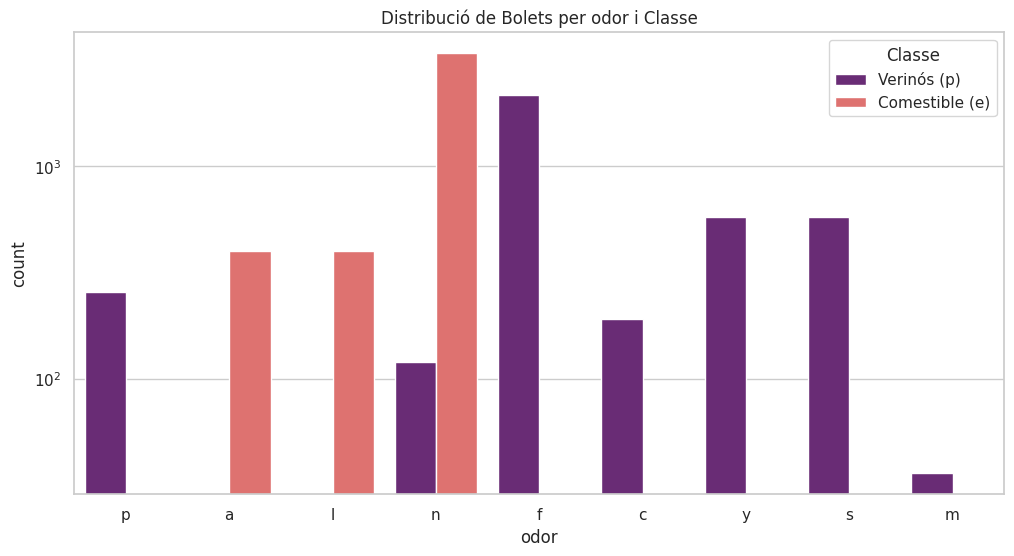

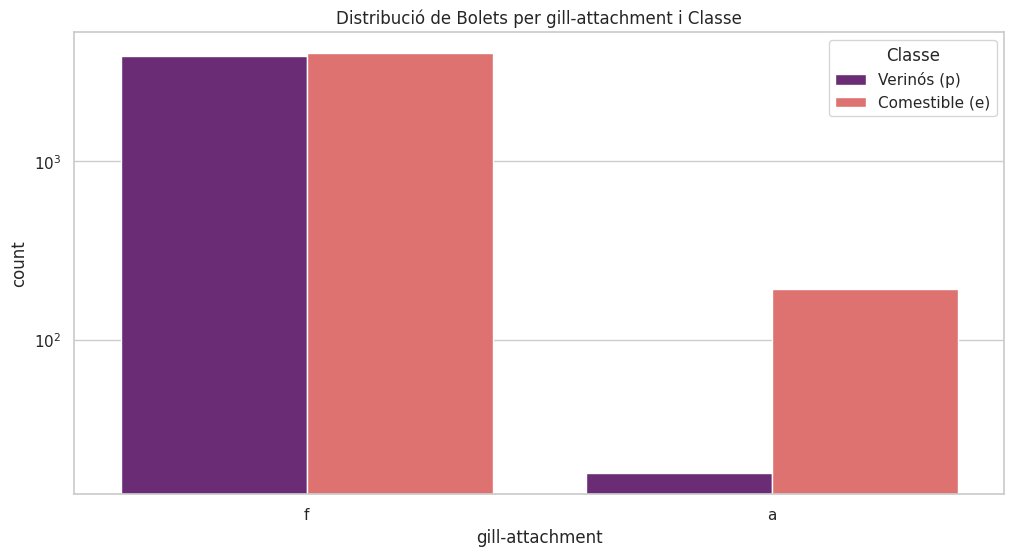

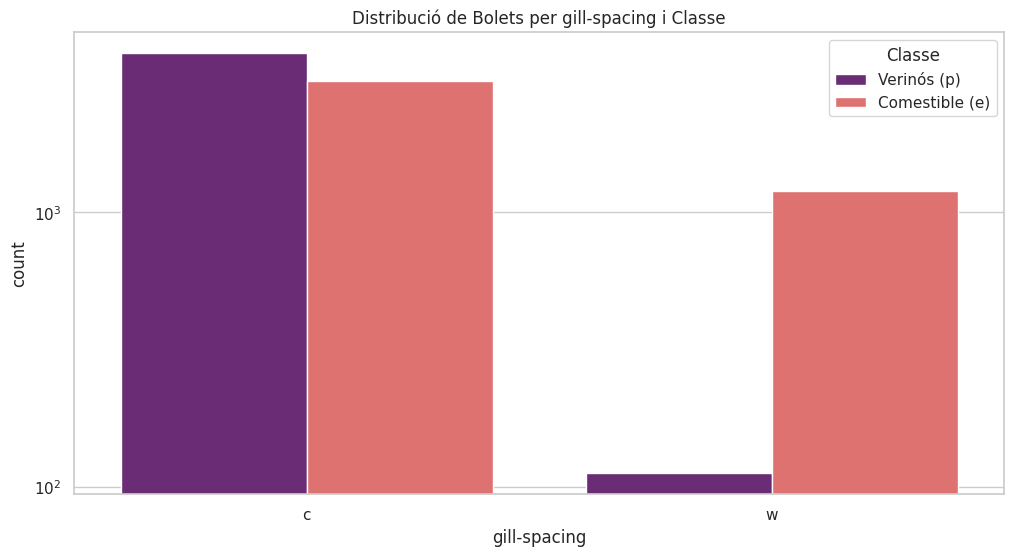

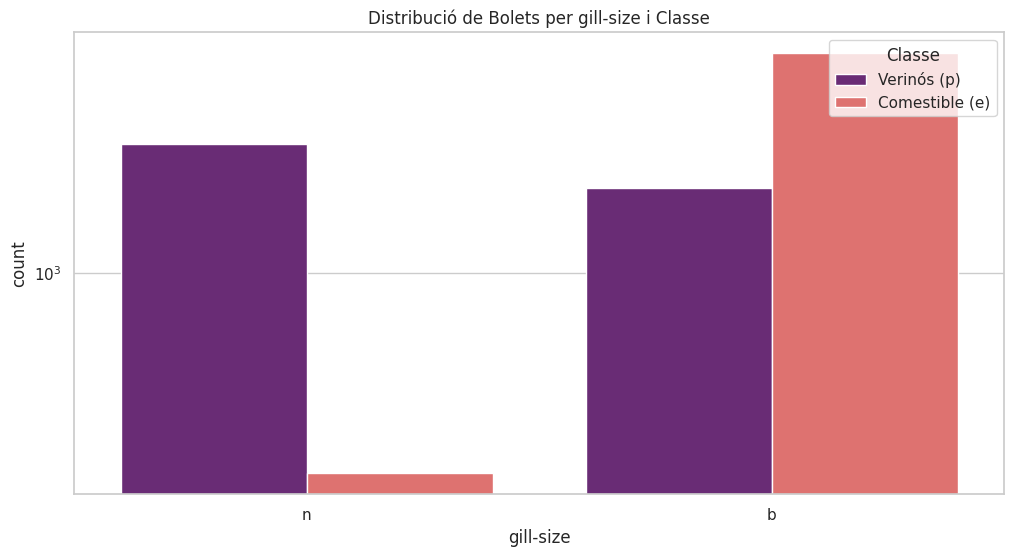

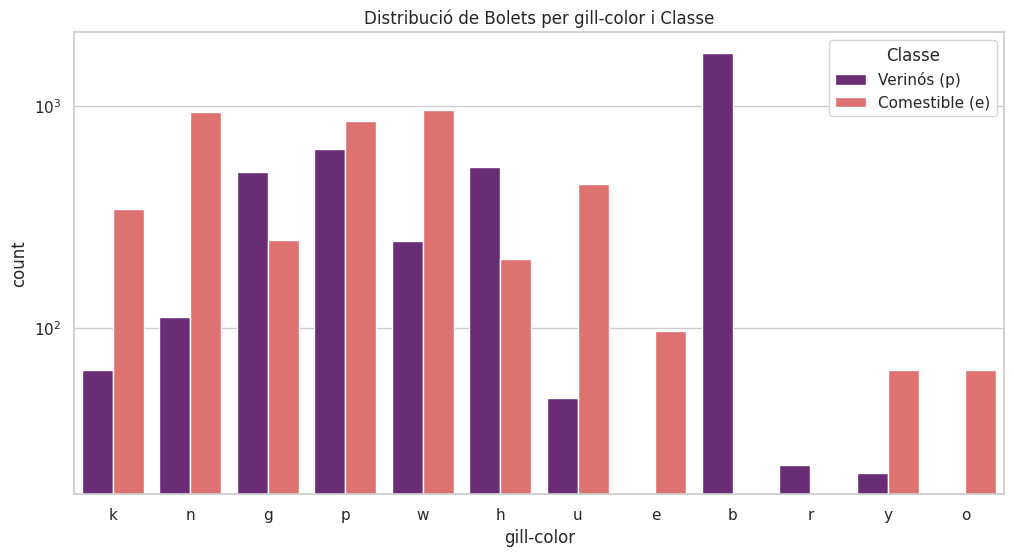

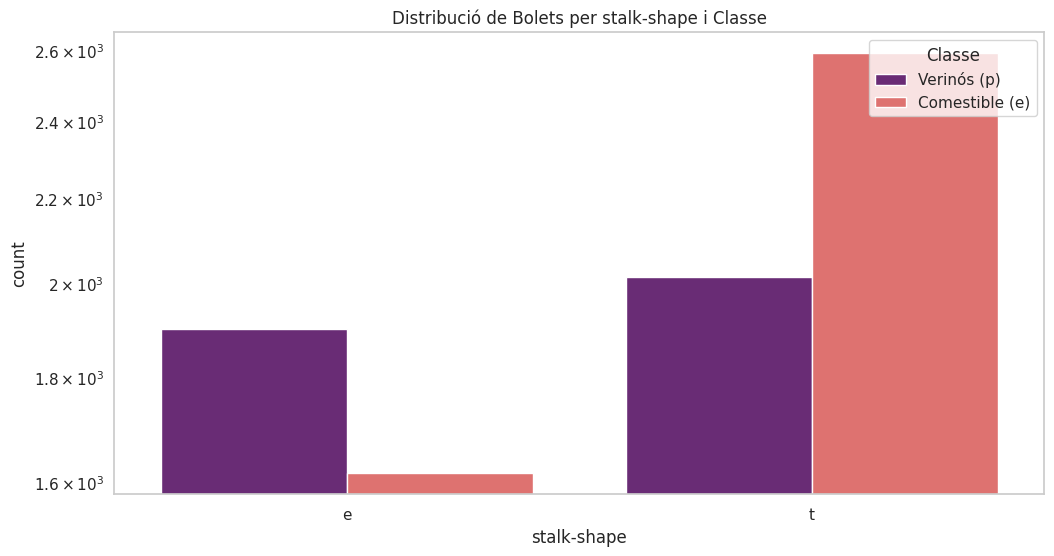

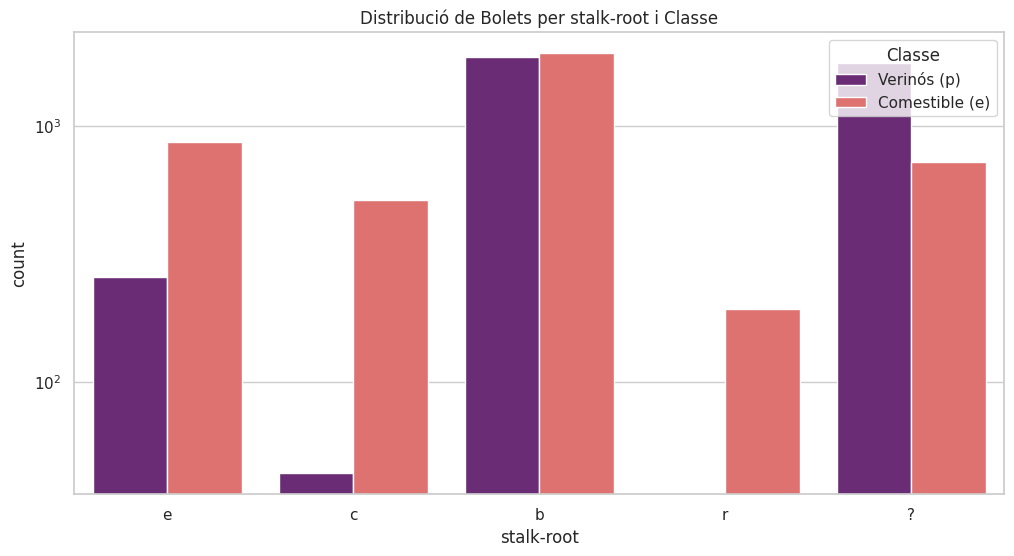

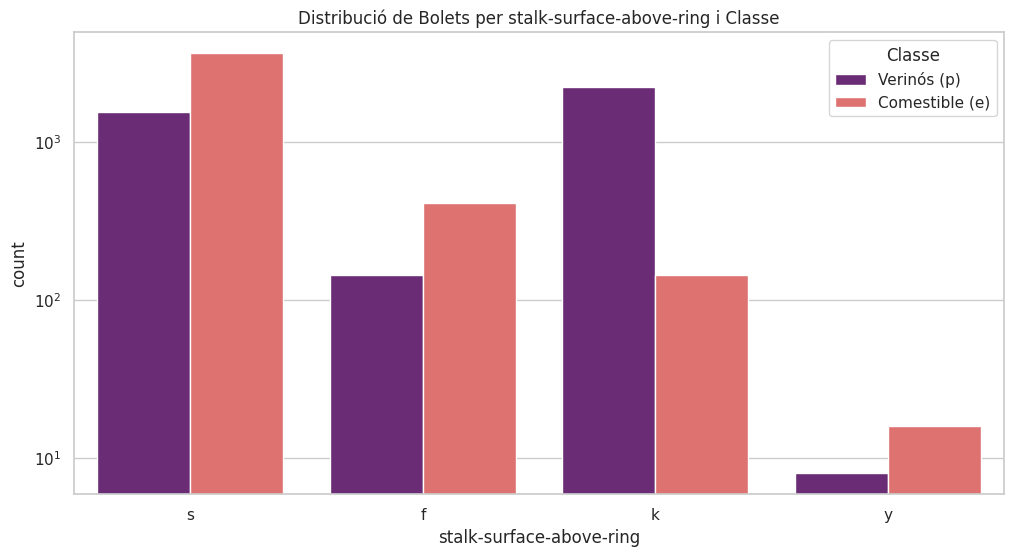

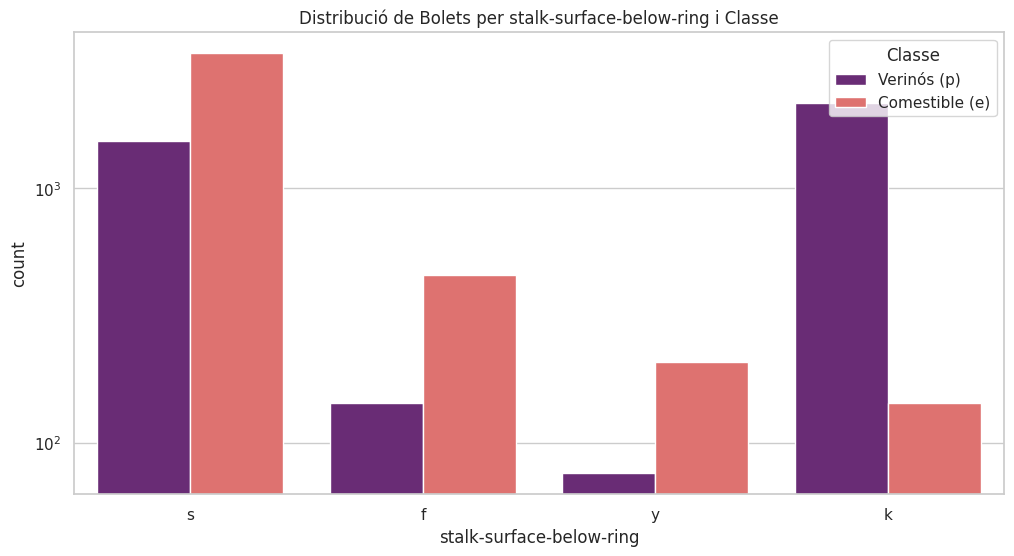

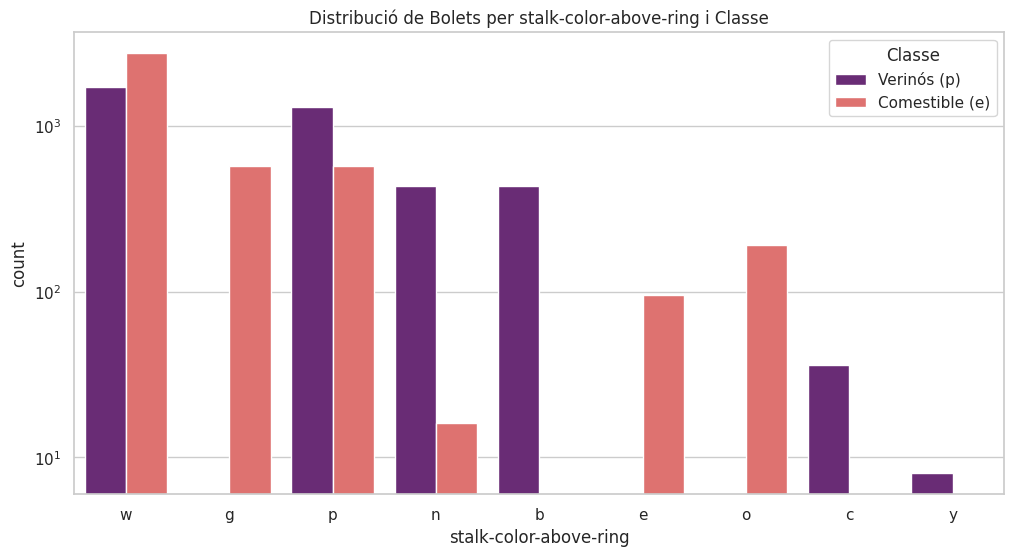

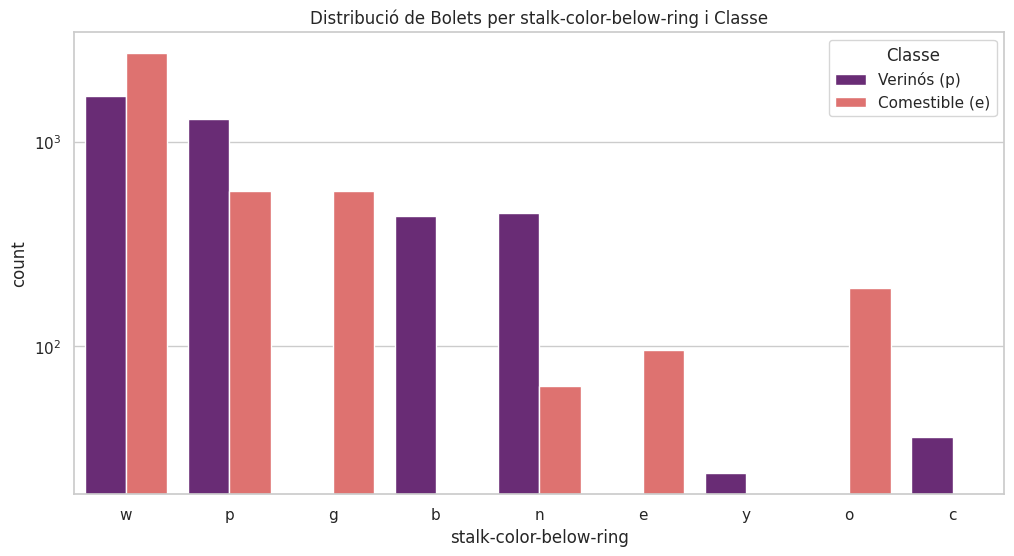

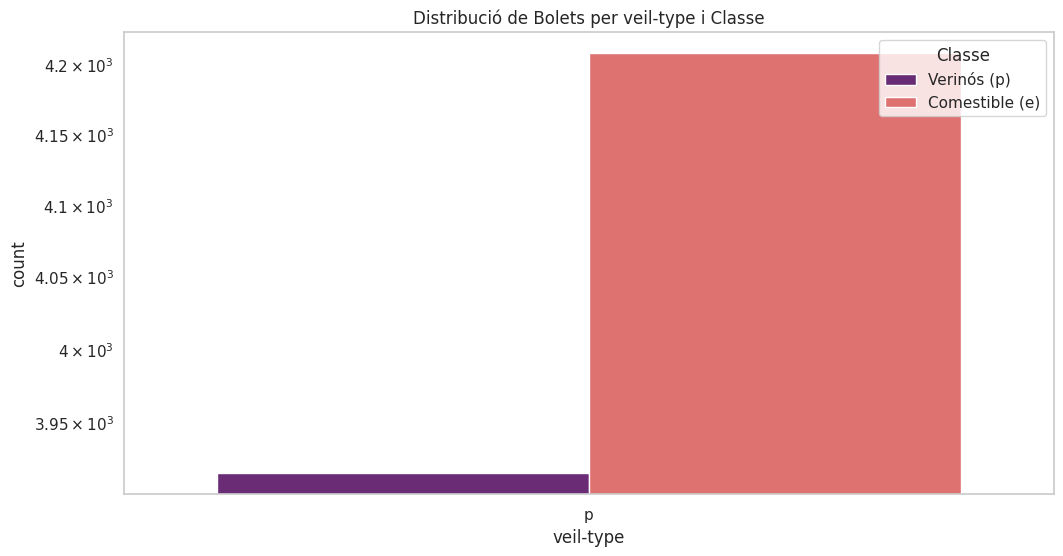

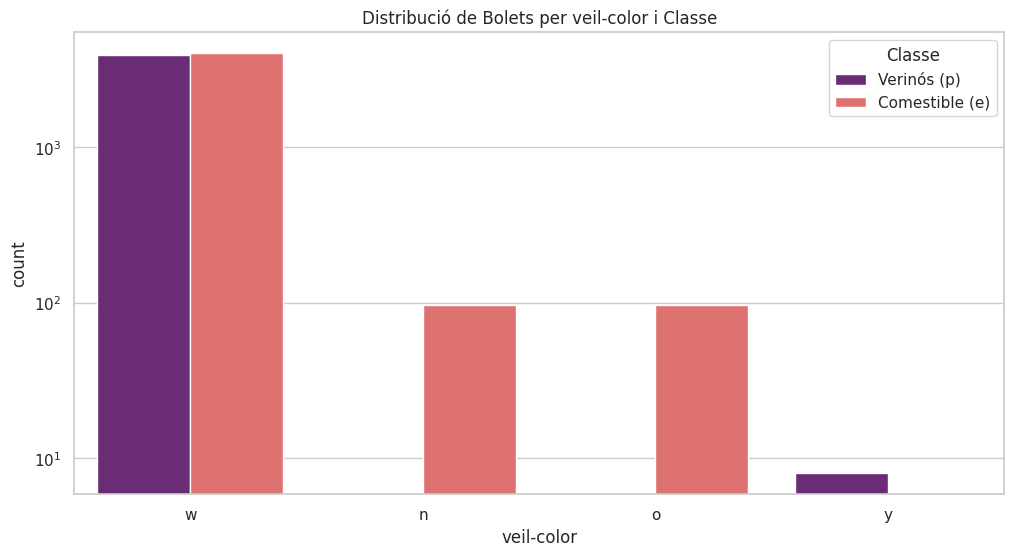

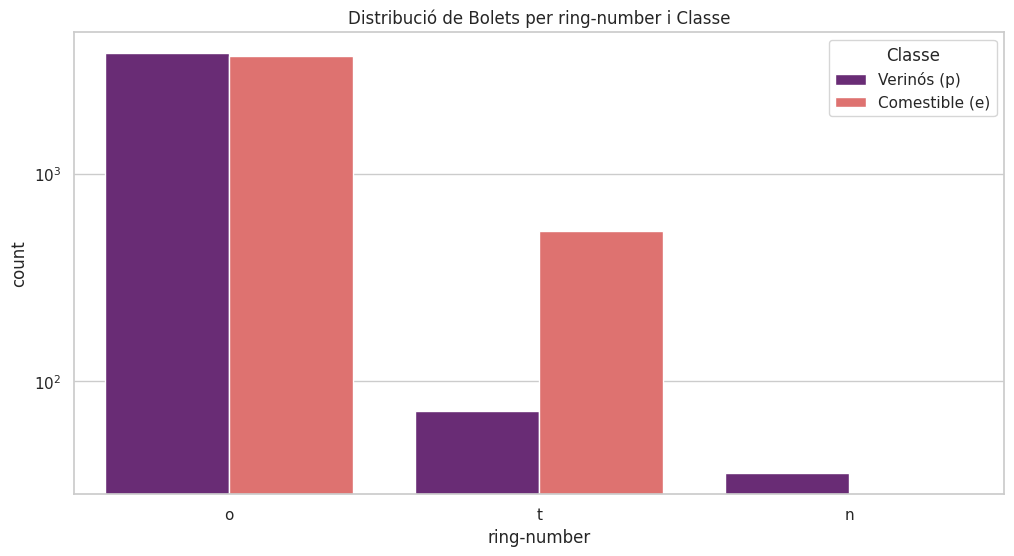

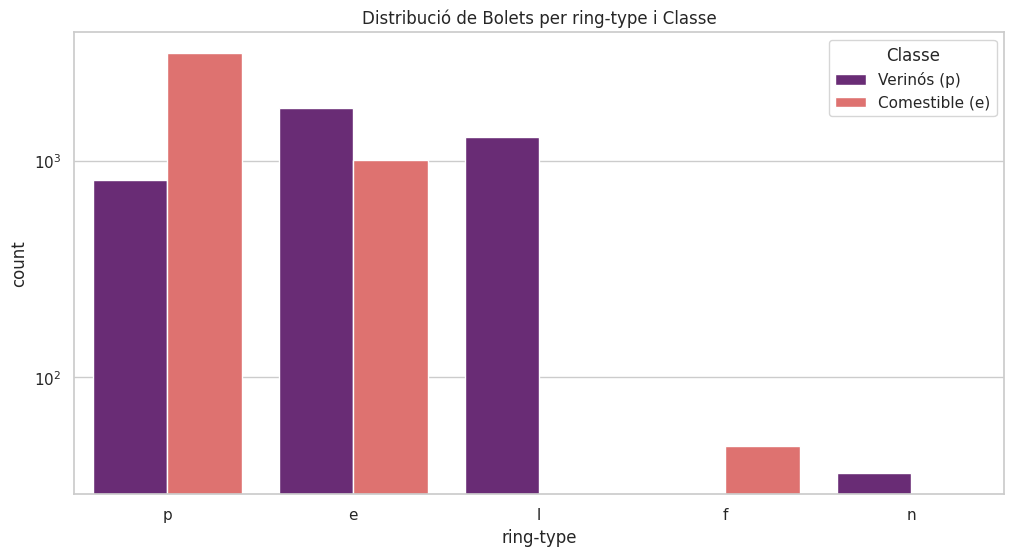

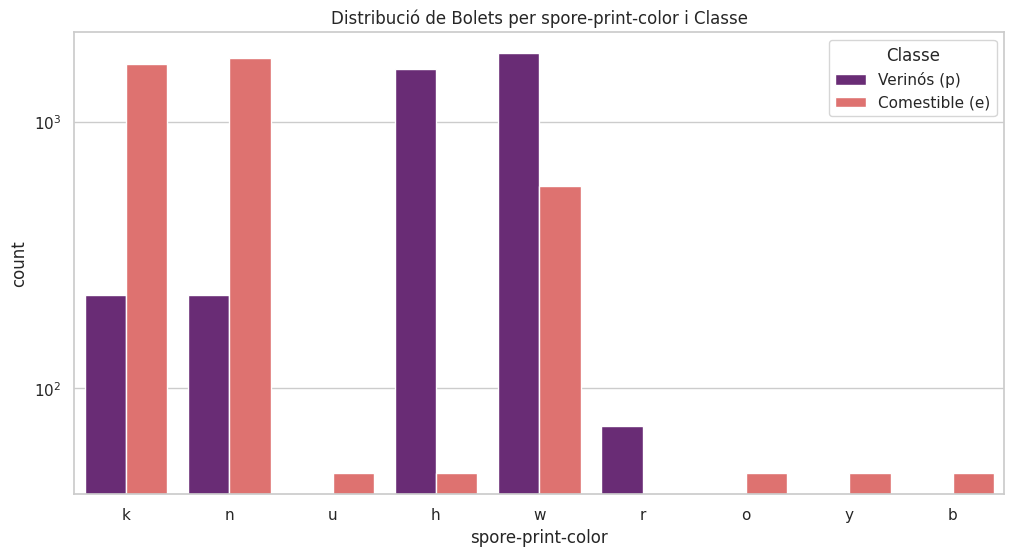

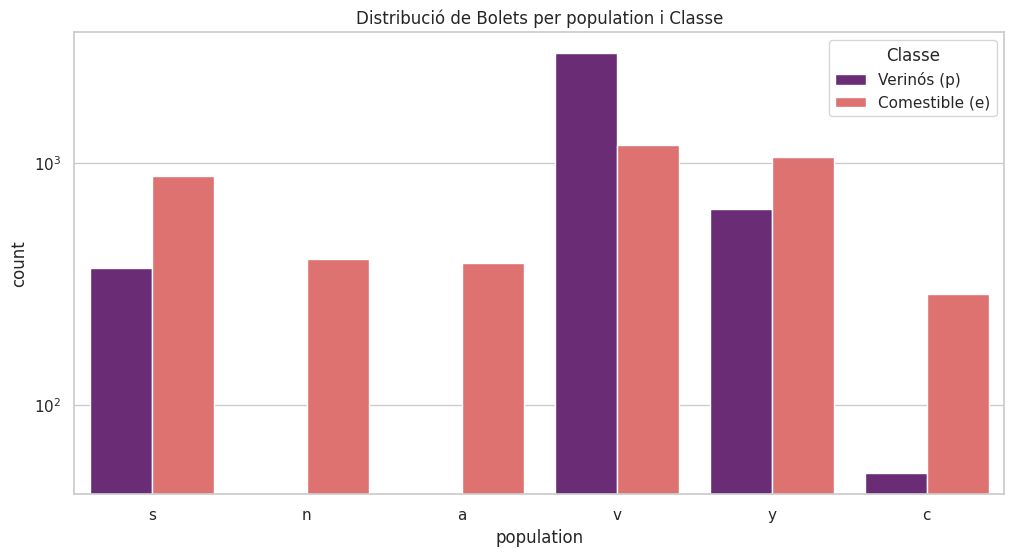

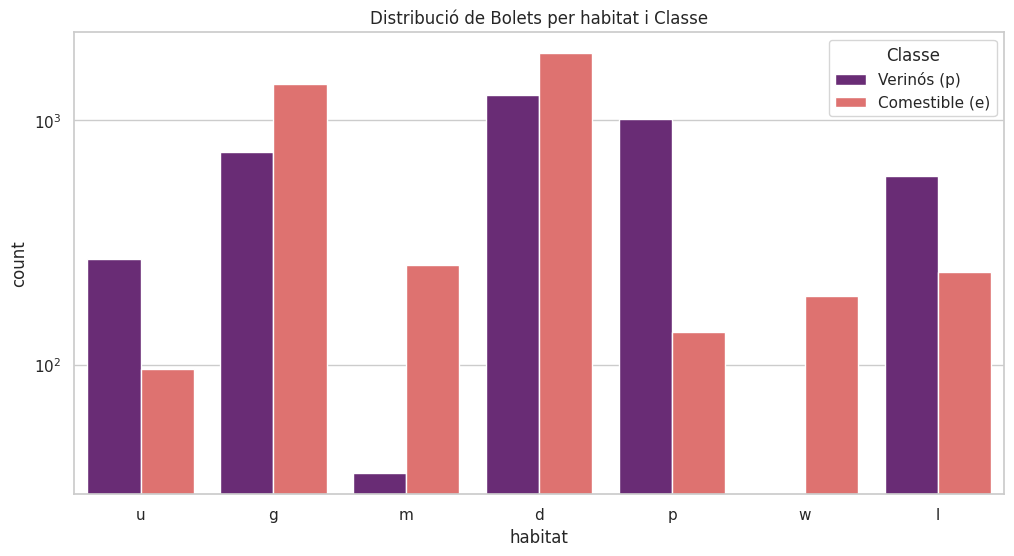

In [15]:
for col in df.drop(columns=['class']):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=col, hue='class', data=df, palette='magma')
    plt.yscale('log')
    plt.title(f'Distribució de Bolets per {col} i Classe')
    plt.legend(title='Classe', loc='upper right', labels=['Verinós (p)', 'Comestible (e)'])
    plt.show()

Amb aquests gràfics podem veure com hi ha atributs que no ens aporten una relació molt clara amb la variable objectiu, com "habitat" o "gill-color". Però també n'hi ha que aporten informació molt valuosa, com "odor", que només permet dubtar de la classificació en la classe "n".

## 3. Preprocessament de Dades (Data Mining)
Com que totes les dades són lletres (categories), utilitzarem Label Encoding per transformar aquestes classes a nombres.

In [16]:
# Creem una còpia per no modificar l'original visualment
df_encoded = df.copy()
le = LabelEncoder()

# Apliquem Label Encoding a totes les columnes
for col in df_encoded.columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


### Mapa de Correlació
Un cop tenim números com a classes, podem veure quines variables estan més correlacionades amb la variable objectiu "class" (que ara serà 0 o 1). Això ens permet veure relacions lineals entre atributs i la variable objectiu, semblant a com hem fet anteriorment individualment per classe i atribut.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


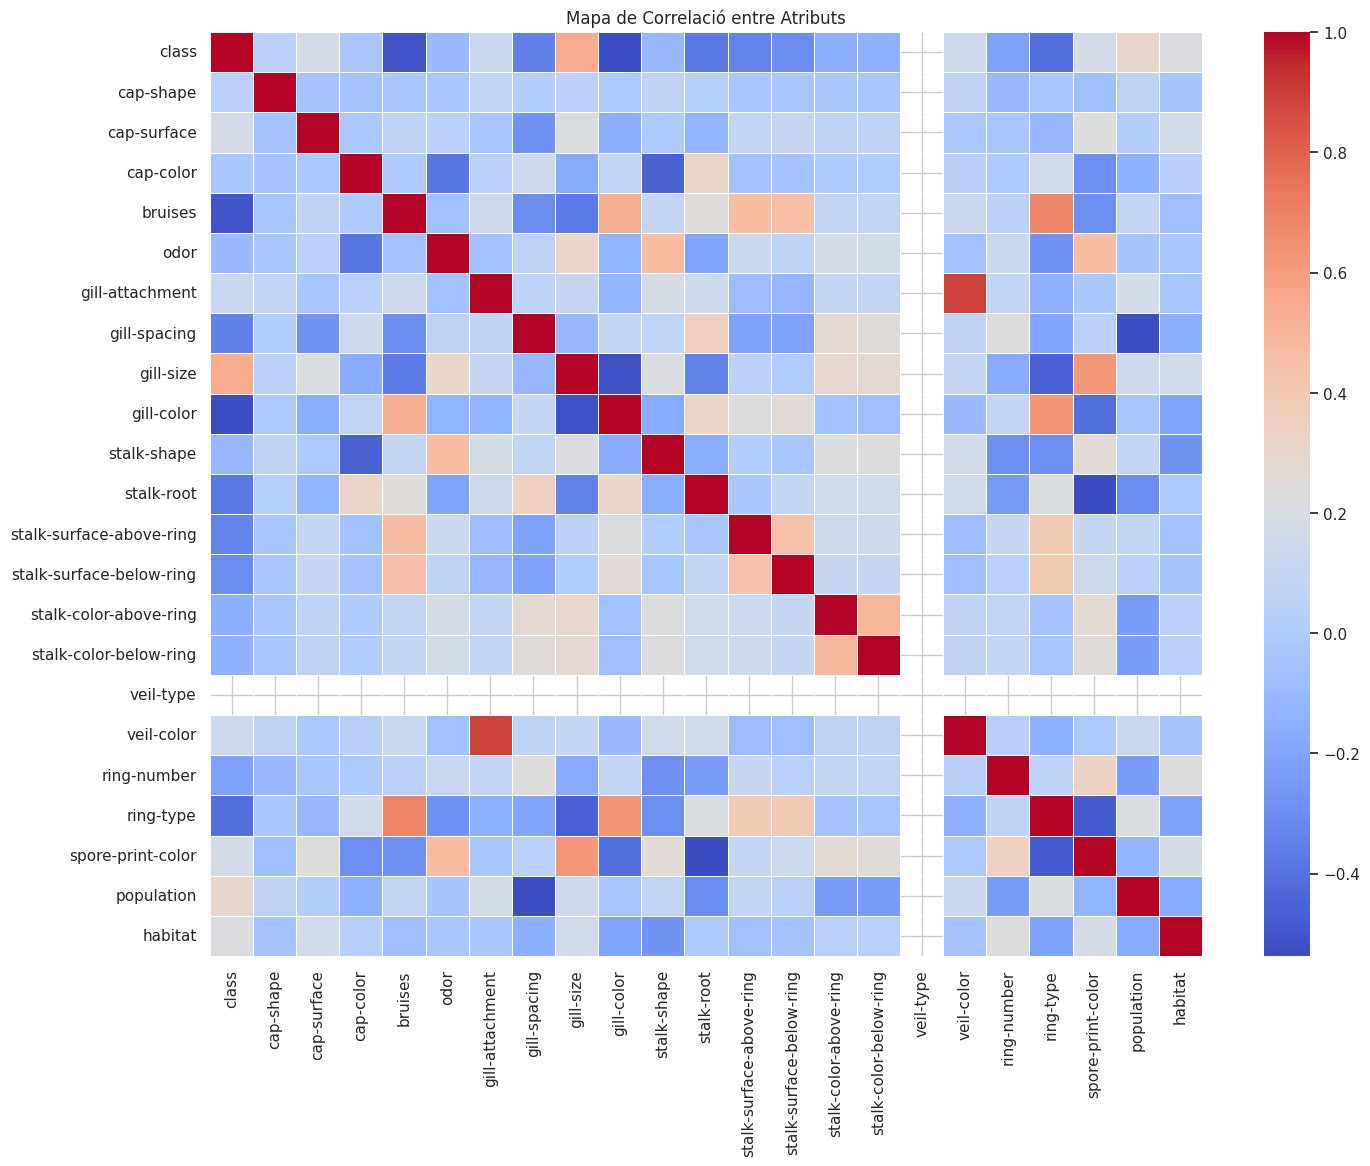

Correlació dels atributs amb la 'class' (ordenat):
class                       1.000000
gill-size                   0.540024
population                  0.298686
habitat                     0.217179
cap-surface                 0.178446
spore-print-color           0.171961
veil-color                  0.145142
gill-attachment             0.129200
cap-shape                   0.052951
cap-color                  -0.031384
odor                       -0.093552
stalk-shape                -0.102019
stalk-color-below-ring     -0.146730
stalk-color-above-ring     -0.154003
ring-number                -0.214366
stalk-surface-below-ring   -0.298801
stalk-surface-above-ring   -0.334593
gill-spacing               -0.348387
stalk-root                 -0.379361
ring-type                  -0.411771
bruises                    -0.501530
gill-color                 -0.530566
veil-type                        NaN
Name: class, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [17]:
plt.figure(figsize=(16, 12))
# Calculem la correlació
correlation = df_encoded.corr()
# Dibuixem el heatmap
sns.heatmap(correlation, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Correlació entre Atributs')
plt.show()

# Veiem la correlació específica amb la variable objectiu 'class'
print("Correlació dels atributs amb la 'class' (ordenat):")
print(correlation['class'].sort_values(ascending=False))